### Importing the required Libraries

In [9]:
import pandas as pd
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import fnmatch
import itertools

In [35]:
from __future__ import print_function
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.utils.np_utils import to_categorical


### Exploration

In [11]:

images = glob('./IDC/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive=True)


In [12]:
print(images[0])

./IDC/breast-histopathology-images/IDC_regular_ps50_idx5/9383/0/9383_idx5_x601_y551_class0.png


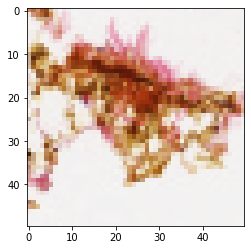

In [13]:
def Print_img(image_path):
    image = cv2.imread(image_path)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
Print_img(images[0])

In [14]:
num_zero = fnmatch.filter(images, '*class0.png') # Contains all the paths with IDC(-)
num_one = fnmatch.filter(images, '*class1.png') # Contains all the paths with IDC(+)


In [15]:
total = len(images)
print(total) # Total number of images. This is what we expected

277524


In [16]:
total_one = len(num_one)
print(len(num_one)) # The number of images iwth IDC(+)

78786


 We see that the dataset is not without it's flaws. The dataset is clearly unbalenced with only 78786 images for IDC(+). Which means almost 71 percent of the dataset has only IDC(-). To balence out the data, the following function will try to have to equal number of both images.

Even randomly choosing the images doesn't seem to be of much help because of the huge size of IDC(-). 

### Data Processing

In [18]:
def create_dataset(para, num_zero, num_one):
    x = []
    y = []
    
    for i in range(0, int(para/2)):
        og = cv2.imread(num_one[i])
        og = cv2.resize(og, (50, 50), interpolation = cv2.INTER_CUBIC)
        x.append(og)
        y.append(1)
    
    k = 0
    for j in range(int(para/2), para):
        og = cv2.imread(num_zero[k])
        og = cv2.resize(og, (50, 50), interpolation = cv2.INTER_CUBIC)
        x.append(og)
        y.append(0)
        k += 1
    
    
    return x, y # Returns the lists containg the images as members. 

In [19]:
# def create_dataset(para, num_zero, num_one):
#     x = []
#     y = []
    
#     size = 0
    
#     for img in images[:para]:
#         og = cv2.imread(img)
#         og = cv2.resize(og, (50, 50), interpolation = cv2.INTER_CUBIC)
#         x.append(og)
#         if img in num_zero:
#             y.append(0)
#         else:
#             y.append(1)
    
#     return x, y
    
    
    
   
    

In [20]:
# x = []
# y = []

# for img in images:
#     x.append(cv2.resize(cv2.imread(img), (50, 50), interpolation = cv2.INTER_CUBIC))
#     if img in num_zero:
#         y.append(0)
#     if img in num_one:
#         y.append(1)




In [21]:
# image_data = pd.DataFrame()




In [22]:
# image_data['images'] = x
# image_data['result'] = y

In [23]:
x, y = create_dataset(90000, num_zero, num_one) # Creating the lists. 

In [24]:
image_data = pd.DataFrame()
image_data["images"] = x
image_data["target"] = y

We see that function solves the unbalenced nature of the data set but only for data sizes such that size/2 <= 78786(number of IDC(+)). If the data set is larger than this then this wont work. Although the function itself works fine it just wont return equal sizes of both types. 

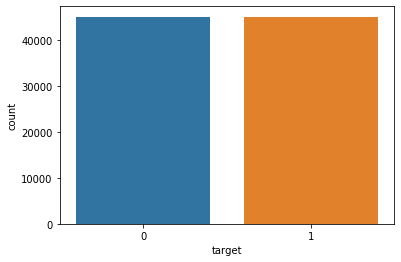

In [25]:
sns.countplot(data=image_data, x='target')

In [26]:
image_data.head()

,images,target
0,"[[[132, 87, 140], [161, 118, 159], [138, 94, 1...",1
1,"[[[148, 103, 142], [171, 127, 175], [190, 161,...",1
2,"[[[146, 105, 132], [163, 117, 157], [161, 120,...",1
3,"[[[199, 176, 196], [143, 99, 166], [152, 111, ...",1
4,"[[[111, 67, 118], [123, 73, 113], [170, 133, 1...",1


Now a few helper functions to make tasks easier and the code less clumsy.

In [27]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    
    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

The above function is used to make the confusion matrix. This function is called within the runkeras function down below after the running fit_generator. 

In [28]:
def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    
    plt.subplot(1,2,2)
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'])
    plt.show()
    



The above function is used for plotting the learning curve. When we use .fit or .fit_generator, the final return value contains the history for each epoch. This data can also be seen without the graphical representaion by mentioning the appropriate verbose level. 

Now we have to convert the data such that it is applicable for training the model. Converting the images into numpy arrays and dividing the values by 255. 

The pixel colour intensity varies form 0 to 255 (8-bit) for Red, Green and Blue individually. But when we have data that lies in between 0 and 1 it is much more compatible many different types of models. 

In [29]:
x = np.array(x)
x = x / 255.0

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, shuffle=True)

Converting the labels into one hot.

In [30]:
y_train_hot = to_categorical(y_train, num_classes = 2)

y_test_hot = to_categorical(y_test, num_classes=2)

###  Training

In [37]:
"""
The following function is based on one of the examples mentioned in the keras github page under examples. 
link: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py
"""


def runkeras(a, b, c, d):
    batch_size = 128
    num_classes = 2
    epochs = 8

    img_rows,img_cols=50,50
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    
    
    datagen = ImageDataGenerator(featurewise_center=False, samplewise_center=False, zca_whitening=False, 
                                 rotation_range=45, width_shift_range=0.2, height_shift_range=0.2, 
                                 horizontal_flip=True, vertical_flip=True)
    #Rotation_range is angluar limit within which the image is randomly rotated.
    # Width_shift_range, hight_shift_range shifts the images randomly by the mentioned amount. 
    
    history = model.fit_generator(datagen.flow(a, b, batch_size=32), steps_per_epoch=len(a) / 32, epochs=epochs,
                                  validation_data=[c, d])
    
    score = model.evaluate(c, d, verbose=0)
    print('Test Loss:', score[0])
    print('Test Accuracy:', score[1])
    
    y_pred = model.predict(c)
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')  
    
    plot_learning_curve(history)
    
    Y_pred_classes = np.argmax(y_pred,axis=1) # Returns the max value of all the values in y_pred
    y_test = np.argmax(d, axis=1) # Return the max value of all the values in the testing set. 
    
    
    confusion_mat = confusion_matrix(y_test, Y_pred_classes)
    
    plot_confusion_matrix(confusion_mat, target_names = list(map_characters.values()))

    


In the above model the use of class_weights is not seen. Class weights is used when the training dataset is unbalenced like the present scenario. However since the function: create_dataset() makes sure that we have equal number of both IDC(+) and IDC(-), the use of class weights is limited here. 

Although when using larger datasets for training especially when the create_dataset() doesn't return equal number we have to use class weights. 

Also the ImageDataGenerator is almost a must. The model can be trained without using and substituting fit_generator with .fit, but the accuracy of the model is very unstable. Such models can't be used to make any meaningful predictions and hence are to be avoided. 

Epoch 1/8
   9/1968 [..............................] - ETA: 1:37:09 - loss: 1.4132 - accuracy: 0.4618

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223123). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


1969/1968 [==============================] - 81s 41ms/step - loss: 0.5246 - accuracy: 0.7540 - val_loss: 0.4247 - val_accuracy: 0.8118
Epoch 2/8
1969/1968 [==============================] - 55s 28ms/step - loss: 0.4590 - accuracy: 0.7959 - val_loss: 0.4195 - val_accuracy: 0.8207
Epoch 3/8
1969/1968 [==============================] - 57s 29ms/step - loss: 0.4415 - accuracy: 0.8078 - val_loss: 0.4129 - val_accuracy: 0.8187
Epoch 4/8
1969/1968 [==============================] - 56s 28ms/step - loss: 0.4273 - accuracy: 0.8158 - val_loss: 0.3924 - val_accuracy: 0.8316
Epoch 5/8
1969/1968 [==============================] - 57s 29ms/step - loss: 0.4159 - accuracy: 0.8199 - val_loss: 0.4122 - val_accuracy: 0.8257
Epoch 6/8
1969/1968 [==============================] - 58s 30ms/step - loss: 0.4119 - accuracy: 0.8231 - val_loss: 0.3818 - val_accuracy: 0.8366
Epoch 7/8
1969/1968 [==============================] - 59s 30ms/step - loss: 0.4067 - accuracy: 0.8264 - val_loss: 0.3826 - val_accuracy: 0.

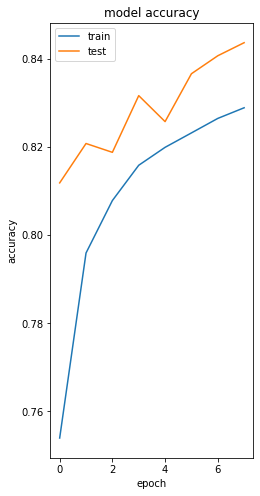

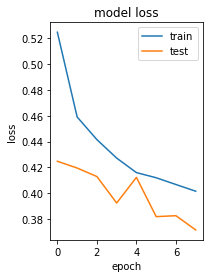

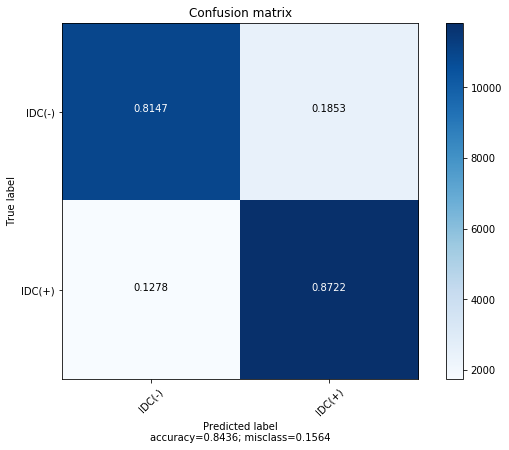

In [38]:
runkeras(x_train, y_train_hot, x_test, y_test_hot)

As you can see that the model has achieved an accuracy of 84% with using 90000 images of the original 277524.

Ways to improve this would be to use more of the dataset and also while doing that class weights should be used in model.fit_generator()